# MODEL

In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import enum

import os
from PIL import Image
import cv2 #pip install opencv-python
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision import datasets, models, transforms
import torchvision
import copy
import sklearn.metrics
import time
import torch.utils
import torch.utils.data
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Reeee

In [2]:
import import_ipynb
# import proeprocess
%run preprocess.ipynb
%run stinna.ipynb
%run extraFunctions.ipynb

# from stinna import plot_confusion_matrix, plot_accuracies
# # from extraFunctions import makeAll, visualize_model, imshow
# from preprocess import *

In [6]:
simple_transformer = transforms.Compose([
        transforms.ToTensor()])

ResNet accepts input images of shape `(3 x 224 x 224)` and they must be loaded in to a range of `[0,1]` and normalised using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` (https://pytorch.org/hub/pytorch_vision_resnet/). Our data already has the correct size, so here, we simply add `ToTensor()`, which converts the images from `(H x W x C)` in range `[0,255]` to `(C x H x W)` in range `[0.0,1.0]`, and the normalisation. 

In [7]:
# TODO move up before dataloaders and create the datasets with this preprocesstransformer instead
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# TODO put in its own cell maybe
# inspired by Lab5's data augmentation
preprocess_with_augmentation = {
    'train': transforms.Compose([
        # add augmentations here, e.g. 
        # transforms.ColorJitter(brightness=0.1),
        # transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        # validation set remains "clean" from augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

Split data into train set, validation set and test set with ratio 80/10/10

In [22]:
# import splitfolders
# splitfolders.ratio(PATHbirdsWithBackground, output="output",seed=42, ratio=(0.8,0.1,0.1) )

Set up paths to data and dataloaders for traning set and validation set

In [8]:
PATH_TEST = "split_withbackground/test"
test_set = datasets.ImageFolder(PATH_TEST, simple_transformer)

PATH_TRAIN = "split_withbackground/train"
train_set = datasets.ImageFolder(PATH_TRAIN, simple_transformer)
train_aug = datasets.ImageFolder(PATH_TRAIN, preprocess)

PATH_VAL = "split_withbackground/val"
val_set = datasets.ImageFolder(PATH_VAL, simple_transformer)
val_aug = datasets.ImageFolder(PATH_VAL, preprocess)
class_labels = val_set.classes
print('Labels: {}'.format(class_labels))

dataset_size_train = len(train_set)
dataset_size_val = len(val_set)
print('No of images in training set: {}'.format(dataset_size_train))
print('No of images in validation set: {}'.format(dataset_size_val))

Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
No of images in training set: 835
No of images in validation set: 104


In [133]:
dataloader_train = torch.utils.data.DataLoader(train_aug, batch_size=4, shuffle=True, num_workers=4)
dataloader_validation = torch.utils.data.DataLoader(val_aug, batch_size=4, shuffle=True, num_workers=4)


subset1 = torch.utils.data.Subset(train_aug, np.random.choice(len(train_aug), 16, replace=False))
subset2 = torch.utils.data.Subset(val_aug, [1,8,9,16, 60, 80, 98, 100, 103, 20,31, 40,50,70,90,88])
print(subset1.dataset)
print(subset1.indices)
print(subset2.dataset)
print(subset2.indices)
dataloader_tiny = DataLoader(subset1, batch_size=4, shuffle=True, num_workers=0)
dataloader_tiny_val = DataLoader(subset2, batch_size=4, shuffle=True, num_workers=0)
# dataloader_aug = torch.utils.data.DataLoader(train_aug, batch_size=4, shuffle=True, num_workers=4)

Dataset ImageFolder
    Number of datapoints: 835
    Root location: split_withbackground/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[746 817  42 562 467 719 695  66  23 796 574 289 755 657 530 189]
Dataset ImageFolder
    Number of datapoints: 104
    Root location: split_withbackground/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[1, 8, 9, 16, 60, 80, 98, 100, 103, 20, 31, 40, 50, 70, 90, 88]


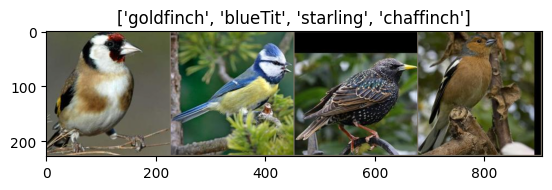

In [155]:
# # Same as above, expect that we are using augmentation_transformer
inputs, classes = next(iter(dataloader_tiny_val))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_set.classes[x] for x in classes])


Import ResNet50 model with the pretrained weights  
https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50

In [20]:
pretrained_weigths = models.ResNet50_Weights.DEFAULT
def load_model(weigths = pretrained_weigths):
    model = resnet50(weights=weigths)
    print(model)
    #Replace last layer to match 7 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 7)
    print(model.fc)
    return model
model = load_model()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Inference transforms perform the following preprocessing operations:  
- Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.  
- The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224].  
- Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Put the pedal to the medal and use GPU

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
def train_model(model, optimizer, num_epoch=5, train = dataloader_train, validation= dataloader_validation):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    best_acc = 0.0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train.item())
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val.item())
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_model_weight = copy.deepcopy(model.state_dict())
        
        time_epoch_val = time.time() - since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Validation accuracies:")
    print(acc_validation)
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation}
    model.load_state_dict(best_model_weight)
    return model, data


In [24]:
# Freeze all layers (i.e., disable training so we dont start from scratch)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc) s.t. we only train that to get a better starting point for fine tuning
for param in model.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

#Use stochastic gradient descent and optimize parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [156]:
trained, data = train_model(model=model,optimizer=optimizer, num_epoch=10, train=dataloader_tiny, validation=dataloader_tiny_val) #took like 4 minutes on device
print(data)

Epoch 1/10
----------
Train Loss: 0.0356 Acc: 0.0012
Val Loss: 0.2743 Acc: 0.0577
Epoch time 0m 7s
----------

Epoch 2/10
----------
Train Loss: 0.0344 Acc: 0.0072
Val Loss: 0.2667 Acc: 0.0673
Epoch time 0m 14s
----------

Epoch 3/10
----------
Train Loss: 0.0332 Acc: 0.0072
Val Loss: 0.2568 Acc: 0.0769
Epoch time 0m 21s
----------

Epoch 4/10
----------
Train Loss: 0.0307 Acc: 0.0132
Val Loss: 0.2473 Acc: 0.0577
Epoch time 0m 28s
----------

Epoch 5/10
----------
Train Loss: 0.0277 Acc: 0.0132
Val Loss: 0.2355 Acc: 0.0673
Epoch time 0m 35s
----------

Epoch 6/10
----------
Train Loss: 0.0260 Acc: 0.0144
Val Loss: 0.2260 Acc: 0.0769
Epoch time 0m 41s
----------

Epoch 7/10
----------
Train Loss: 0.0233 Acc: 0.0144
Val Loss: 0.2213 Acc: 0.0769
Epoch time 0m 48s
----------

Epoch 8/10
----------
Train Loss: 0.0197 Acc: 0.0156
Val Loss: 0.2154 Acc: 0.0962
Epoch time 0m 55s
----------

Epoch 9/10
----------
Train Loss: 0.0196 Acc: 0.0144
Val Loss: 0.2080 Acc: 0.0962
Epoch time 1m 2s
------

In [69]:
model = trained
# Unfreeze all layers such that we can fine-tune the model
for param in model.parameters():
    param.requires_grad = True

model, data = train_model(model, optimizer, num_epoch=6, train=dataloader_tiny, validation=dataloader_tiny_val) #took like 24 min

Epoch 1/6
----------
Train Loss: 0.0306 Acc: 0.0144
Val Loss: 0.1273 Acc: 0.0096
Epoch time 0m 6s
----------

Epoch 2/6
----------
Train Loss: 0.0299 Acc: 0.0144
Val Loss: 0.1289 Acc: 0.0096
Epoch time 0m 12s
----------

Epoch 3/6
----------
Train Loss: 0.0276 Acc: 0.0132
Val Loss: 0.1323 Acc: 0.0000
Epoch time 0m 18s
----------

Epoch 4/6
----------
Train Loss: 0.0247 Acc: 0.0156
Val Loss: 0.1366 Acc: 0.0000
Epoch time 0m 24s
----------

Epoch 5/6
----------
Train Loss: 0.0222 Acc: 0.0144
Val Loss: 0.1418 Acc: 0.0000
Epoch time 0m 30s
----------

Epoch 6/6
----------
Train Loss: 0.0199 Acc: 0.0156
Val Loss: 0.1420 Acc: 0.0000
Epoch time 0m 35s
----------

Training complete in 0m 35s
Validation accuracies:
[0.009615384615384616, 0.009615384615384616, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# visualize_model(model)

# # plt.ioff()
# # plt.ion()
# plt.show()

[[0 0 2 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 1]]


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (7).

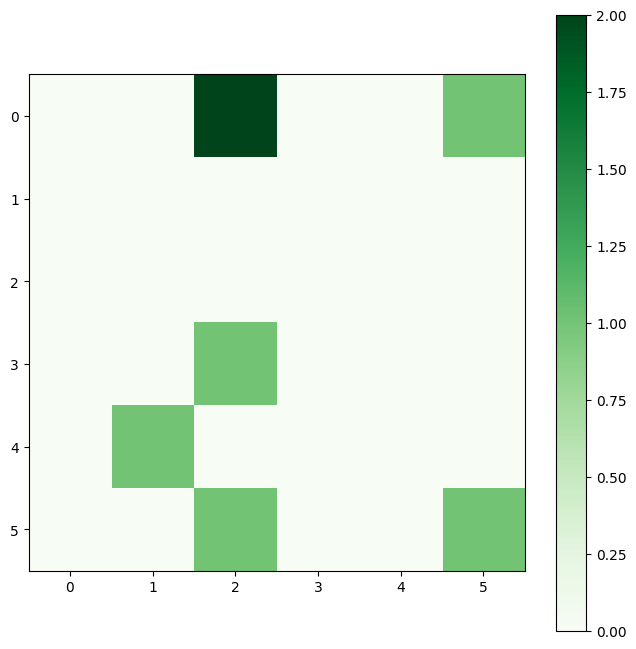

In [ ]:
%run stinna.ipynb

truel, predl = makeAll(dataloader_validation, model, device)

plot_confusion_matrix(truel, predl, class_labels)

In [ ]:
plot_confusion_matrix(truel, predl, class_labels)

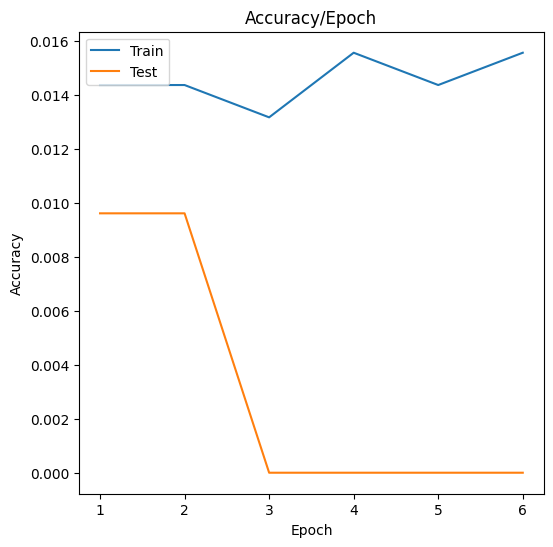

In [70]:
plot_accuracies(data["train_acc"], data["val_acc"])

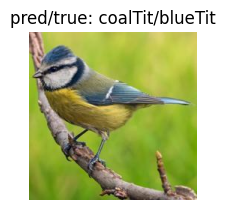

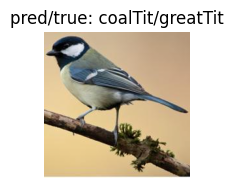

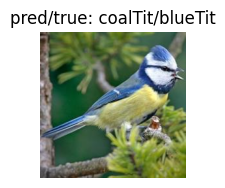

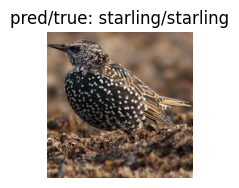

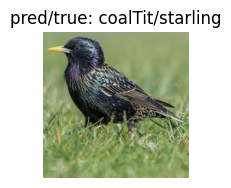

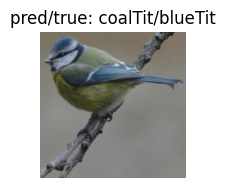

In [71]:
visualize_model(model, dataloader_tiny_val, train_set.classes, device)